In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn import datasets
from sklearn.model_selection import train_test_split

import datetime
from dateutil.parser import parse

%matplotlib inline

### BayWheel Analytics and Prediction
#### Niva Alina Ran

This project looks at the BayWheel bikesharing dataset (source: https://www.lyft.com/bikes/bay-wheels/system-data). I'm interested in predicting certain quantities of interest using known covariates, as well as exploratory data analysis. I experiment with a few ML algortihms including linear regression and random forests. 

In [44]:
df_raw = pd.read_csv("201910-baywheels-tripdata.csv")
print(df_raw.columns)
df_raw.head(5)

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip'],
      dtype='object')


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,62337,2019-10-31 16:25:01.5970,2019-11-01 09:43:59.0290,148,Horton St at 40th St,37.829705,-122.287610,385,Woolsey St at Sacramento St,37.850578,-122.278175,12222,Customer,NaN,NaN,No
1,72610,2019-10-31 13:04:11.1950,2019-11-01 09:14:21.8050,376,Illinois St at 20th St,37.760458,-122.387540,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,282,Customer,NaN,NaN,No
2,56636,2019-10-31 17:17:37.6480,2019-11-01 09:01:33.7720,453,Brannan St at 4th St,37.777934,-122.396973,453,Brannan St at 4th St,37.777934,-122.396973,10940,Customer,NaN,NaN,No
3,42250,2019-10-31 20:11:11.1270,2019-11-01 07:55:21.7440,182,19th Street BART Station,37.809369,-122.267951,163,Lake Merritt BART Station,37.797320,-122.265320,12623,Subscriber,1997.0,Male,No
4,40076,2019-10-31 18:48:32.1410,2019-11-01 05:56:28.4670,237,Fruitvale BART Station,37.775232,-122.224498,237,Fruitvale BART Station,37.775232,-122.224498,2601,Customer,NaN,NaN,No


In [32]:
## Add hour of day and day of week features
dt_vec = df_raw['start_time'].apply(lambda x: parse(x))
hod_col = dt_vec.apply(lambda x: x.hour)
dow_col = dt_vec.apply(lambda x: x.weekday())
    
df_raw["start_hour_of_day"] = hod_col
df_raw["start_day_of_week"] = dow_col

### Exploratory Data Analysis

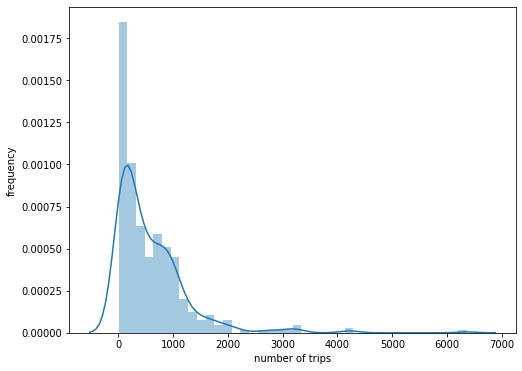

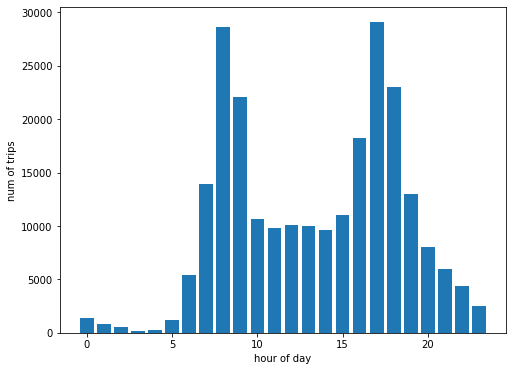

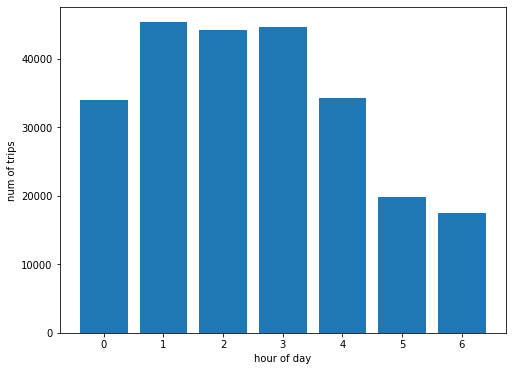

In [5]:
# Plot histogram of trip starting times by station
df=df_raw

station_id_list = np.sort(df["start_station_id"].unique())


##  historgram of total trips from a station
trip_count_vec = np.zeros(len(station_id_list))
for i in range(len(trip_count_vec)):
    this_staion_id = station_id_list[i]
    df_this_station = df[df["start_station_id"]==this_staion_id]
    trip_count_vec[i] = len(df_this_station)
    
plt.figure(figsize=(8,6))
sns.distplot(trip_count_vec,bins=40)
plt.ylabel("frequency");
plt.xlabel("number of trips");
plt.show()

##  historgram of number of trips per hour of day
trip_per_hour_day_vec = np.zeros(24)
for i in range(24):
    trip_per_hour_day_vec[i] = len(df[df["start_hour_of_day"]==i])

plt.figure(figsize=(8,6))
plt.bar(range(24), trip_per_hour_day_vec)
plt.ylabel("num of trips");
plt.xlabel("hour of day");


##  historgram of number of trips per hour of day
trip_per_day_of_week = np.zeros(7)
for i in range(7):
    trip_per_day_of_week[i] = len(df[df["start_day_of_week"]==i])

plt.figure(figsize=(8,6))
plt.bar(range(7), trip_per_day_of_week)
plt.ylabel("num of trips");
plt.xlabel("hour of day");

In [6]:
### Create new data set grouped by station
df_stat = pd.DataFrame([])
df_stat["station_id"] = station_id_list

df_stat["start_station_latitude"]  = df_stat["station_id"].apply(lambda x: float(df_raw[df_raw["start_station_id"] == x].head(1)["start_station_latitude"]))
df_stat["start_station_longitude"] = df_stat["station_id"].apply(lambda x: float(df_raw[df_raw["start_station_id"] == x].head(1)["start_station_longitude"]))
df_stat["start_trip_count"] = df_stat["station_id"].apply(lambda x: len(df_raw[df_raw["start_station_id"] == x]))

In [8]:
### Visualize bike usage by starting station
from folium import plugins
import folium as folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

m = folium.Map([37.7756925, -122.4204695], zoom_start=13)
# convert to (n, 2) nd-array format for heatmap
station_data = df_stat[['start_station_latitude', 'start_station_longitude', 'start_trip_count']].values

## Convert startig trip count to quantiles for visualization
d = station_data[:,2]
qrange = np.arange(0,100,1.25)
quantiles = np.percentile(d, qrange)
station_data[:,2] = np.searchsorted(quantiles, d)/len(qrange)

# plot heatmap
m.add_child(plugins.HeatMap(station_data, max_zoom = 13, max_val=1, radius = 8, blur=2))

### Learning a bike demand distribution map using K-nearest neighbors

In [26]:
from sklearn.neighbors import KNeighborsRegressor

station_data = df_stat[['start_station_latitude', 'start_station_longitude', 'start_trip_count']].values
X = station_data[:,[0, 1]]
y = station_data[:,2]
neigh = KNeighborsRegressor(n_neighbors=4, weights = 'distance')
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='distance')

In [45]:
## Define grid coordinate range
coor_ll = np.array([37.748566, -122.437034]) #lower left coordinate
coor_ur = np.array([37.802819, -122.392905]) #upper right coordiante
grid_size = 20 #number of points on each side of the grid


grid_lat, grid_long = np.mgrid[coor_ll[0]:coor_ur[0]:(coor_ur[0]-coor_ll[0])/grid_size, coor_ll[1]:coor_ur[1]:(coor_ur[1]-coor_ll[1])/grid_size] 
grid_lat = np.ndarray.flatten(grid_lat)
grid_long = np.ndarray.flatten(grid_long)

# Predicting Demand
X = np.stack((grid_lat, grid_long), axis= -1)
y_pred = np.transpose(neigh.predict(X))
station_data = np.stack((grid_lat, grid_long, y_pred), axis=-1)

## Convert startig trip count to quantiles for visualization
d = station_data[:,2]
qrange = np.arange(0,100,1.25)
quantiles = np.percentile(d, qrange)
station_data[:,2] = np.searchsorted(quantiles, d)/len(qrange)

# Visualization with map
cor_ref_start = (coor_ll+coor_ur)/2
m = folium.Map(cor_ref_start, zoom_start=13)

# plot heatmap
m.add_child(plugins.HeatMap(station_data, max_zoom = 13, max_val=1, radius = 6, blur=1))
m

### Per-Trip Predictions

In [35]:
## Sub-sample raw day for visualization and learning

N=8000

col_used =[
    "duration_sec", 
    "start_station_id",
    'start_station_latitude',
    'start_station_longitude', 
    'end_station_id', 
    'end_station_latitude', 
    'end_station_longitude',
    'start_hour_of_day',
    'start_day_of_week']

df= df_raw[col_used]
df = df.sample(n=N)

### Scatter Plot 

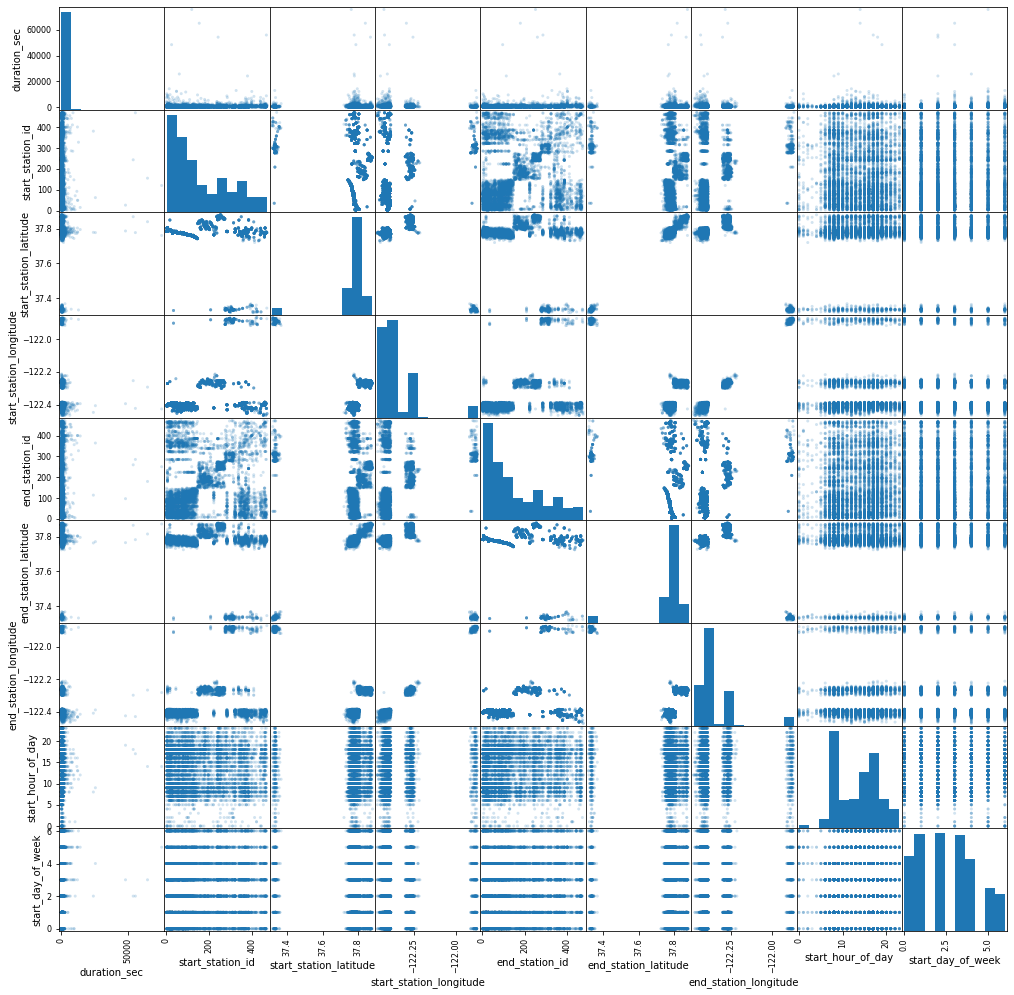

In [36]:
col_used =[
    "duration_sec", 
    "start_station_id",
    'start_station_latitude',
    'start_station_longitude', 
    'end_station_id', 
    'end_station_latitude', 
    'end_station_longitude',
    'start_time']

scatter_matrix(df, alpha=0.2, figsize=(17, 17));

### Create Predictive Models

In [37]:
x_feat = [
    "start_station_id",
    'start_station_latitude',
    'start_station_longitude',
    'start_hour_of_day',
    'start_day_of_week']

y_feat = ['end_station_latitude']

training_frac  = 0.5

x_train = df[x_feat].head(int(len(df)*training_frac))
y_train = df[y_feat].head(int(len(df)*training_frac))

x_test = df[x_feat].tail(int(len(df)*(1-training_frac)))
y_test = df[y_feat].tail(int(len(df)*(1-training_frac)))


### Linear Regression Model


In [38]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
coefdf = pd.DataFrame(np.transpose(lr.coef_), columns = ['coef'])
coefdf.insert(0, "features", np.transpose(x_feat))
coefdf

,features,coef
0,start_station_id,0.000009
1,start_station_latitude,0.969826
2,start_station_longitude,-0.023606
3,start_hour_of_day,-0.000303
4,start_day_of_week,-0.000148


MSE = 0.00019383697012629334


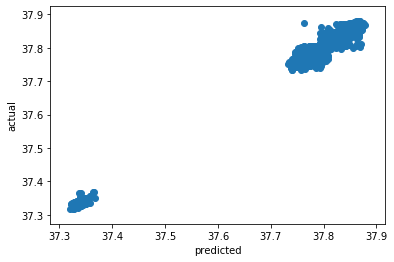

In [39]:
### Prediction 
y_pred = lr.predict(x_test);

### Performance Evaluation 
plt.scatter(y_pred, y_test);
plt.ylabel("actual");
plt.xlabel("predicted");

# Mean squared error
mse = np.mean(np.array((y_test - y_pred)**2));
print("MSE = "+str(mse));

### Random Forest Regressor


In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=0)

rf.fit(x_train,y_train.values.ravel());

MSE = 0.020538265751628596


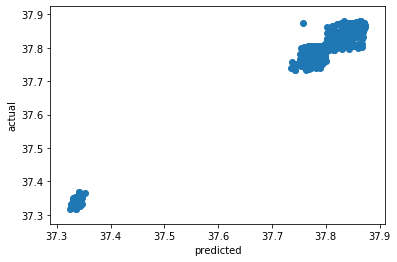

In [41]:
### Prediction 
y_pred = rf.predict(x_test);

### Performance Evaluation 
plt.scatter(y_pred, y_test);
plt.ylabel("actual");
plt.xlabel("predicted");

# Mean squared error
mse = np.mean((np.array(y_test) - np.array(y_pred))**2)
print("MSE = "+str(mse));


In [42]:
### Visualize Decision Tree
from sklearn.tree import export_graphviz
import os 

# Extract single tree
tree = rf.estimators_[1]

# Export as dot file
export_graphviz(tree, out_file='tree.dot', 
                feature_names = x_feat,
                class_names = y_feat,
                rounded = True, proportion = True, 
                precision = 2, filled = True,
                max_depth= 3)

# Convert to png using system command (requires Graphviz)
os.system('dot -Tpng tree.dot -o tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'tree.png'